In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os

In [3]:
#Uses gpu if available
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(0)
batch_size = 256

#Downloads datasets
image_size = (224, 224)
transform = transforms.Compose([transforms.Resize(image_size), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
dataset = torchvision.datasets.Imagenette(root='./data', download=False, transform=transform) #Set download to true first time
class_names = dataset.classes

#Split for cross validation
test_size = len(dataset) // 6
train_size = len(dataset) - test_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

#Creates DataLoaders for each set
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=6, pin_memory=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=6, pin_memory=True)


In [4]:
#Defines class for a residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, kernel_size, halving):
        super().__init__()

        #If halving is true, the feature size is cut in half and the out_channels is doubled
        out_channels = in_channels
        stride1 = 1
        stride2 = 1
        if halving:
            out_channels *= 2
            stride1 = 2

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=stride2, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride1, padding=1), \
                                        nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=stride2, padding=1)) if halving else None

    def forward(self, x):
        #Keeps activation from previous layer to add as residual later
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        #Normal convolution
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)

        #Adds residual
        x += identity
        out = F.relu(x)
        return out


In [5]:
#Defines Convolutional Neural Network

class Resnet(nn.Module):
    def __init__(self,):
        super().__init__()

        #Residual/Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=5, stride=2, padding=2)
        self.reslayers = nn.ModuleList()

        self.reslayers.append(ResidualBlock(in_channels=64, kernel_size=3, halving=False))
        self.reslayers.append(ResidualBlock(in_channels=64, kernel_size=3, halving=False))
        self.reslayers.append(ResidualBlock(in_channels=64, kernel_size=3, halving=False))

        self.reslayers.append(ResidualBlock(in_channels=64, kernel_size=3, halving=True))

        self.reslayers.append(ResidualBlock(in_channels=128, kernel_size=3, halving=False))
        self.reslayers.append(ResidualBlock(in_channels=128, kernel_size=3, halving=False))
        self.reslayers.append(ResidualBlock(in_channels=128, kernel_size=3, halving=False))

        self.reslayers.append(ResidualBlock(in_channels=128, kernel_size=3, halving=True))

        self.reslayers.append(ResidualBlock(in_channels=256, kernel_size=3, halving=False))
        self.reslayers.append(ResidualBlock(in_channels=256, kernel_size=3, halving=False))
        self.reslayers.append(ResidualBlock(in_channels=256, kernel_size=3, halving=False))
        self.reslayers.append(ResidualBlock(in_channels=256, kernel_size=3, halving=False))
        self.reslayers.append(ResidualBlock(in_channels=256, kernel_size=3, halving=False))
        self.reslayers.append(ResidualBlock(in_channels=256, kernel_size=3, halving=False))

        self.reslayers.append(ResidualBlock(in_channels=256, kernel_size=3, halving=True))

        self.reslayers.append(ResidualBlock(in_channels=512, kernel_size=3, halving=False))
        self.reslayers.append(ResidualBlock(in_channels=512, kernel_size=3, halving=False))

        self.pool2 = nn.AvgPool2d(kernel_size=7,stride=1)

        #Fully connected layers
        self.flatten = nn.Flatten()
        self.out = nn.Linear(in_features=512, out_features=10)


    def forward(self, x):
        #Residual/Convolutional layers with ReLU activation function
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool1(x)

        for reslayer in self.reslayers:
            x = reslayer(x)

        x = self.pool2(x)

        #Fully connected layer with ReLU activation
        x = self.flatten(x)
        out = F.relu(self.out(x))
        
        return out

In [6]:
#Iterates through a training epoch while displaying performance metrics by batch
def train_epoch(network, optimizer, criterion):
    network.train(True)
    running_loss = 0.0
    running_accuracy = 0.0

    # Generate numpy arrays to save our training data and plot it
    save_every = 5
    batches = []
    losses = []
    accuracy = []
    batch_count_avg = 0

    for batch_index, data in enumerate(trainloader):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()

        outputs = network(inputs)
        num_correct = torch.sum(labels == torch.argmax(outputs, dim=1)).item()
        running_accuracy += num_correct / batch_size

        loss = criterion(outputs, labels)
        running_loss += loss.item()
        batch_count_avg += 1
        loss.backward()
        optimizer.step()

        if batch_index % save_every == 0:
            avg_loss_across_batches = running_loss / batch_count_avg
            avg_acc_across_batches = (running_accuracy / batch_count_avg) * 100
            batches.append(batch_index)
            losses.append(avg_loss_across_batches)
            accuracy.append(avg_acc_across_batches)
            print('Batch{0}, Loss: {1:.3f}, Accuracy: {2:.1f}%'.format(batch_index+1, avg_loss_across_batches, avg_acc_across_batches))
            running_loss = 0
            running_accuracy = 0
            batch_count_avg = 0

    return batches, losses, accuracy

    

#Optional method to evaluate performance on validation data
def validate_epoch(network, criterion):
    network.train(False)
    running_loss = 0.0
    running_accuracy = 0.0

    for i, data in enumerate(testloader):
        inputs, labels = data[0].to(device), data[1].to(device)

        with torch.no_grad():
            outputs = network(inputs)
            num_correct = torch.sum(labels == torch.argmax(outputs, dim=1)).item()
            running_accuracy += num_correct / batch_size

            loss = criterion(outputs, labels)
            running_loss += loss.item()


    avg_loss_across_batches = running_loss / len(testloader)
    avg_accuracy_across_batches = (running_accuracy / len(testloader)) * 100
    print('Val Loss: {0:.3f}, Val Accuracy: {1:.1f}%'.format(avg_loss_across_batches, avg_accuracy_across_batches))
    print('*****************************************')
    print()

    return avg_loss_across_batches, avg_accuracy_across_batches
            

In [7]:
def new_plot(batches_training, losses_training, accuracies_training, batches_validation, losses_validation, accuracies_validation):
    fig, ax = plt.subplots(4, 1, sharex=True)
    ax[0].clear()
    ax[0].plot(batches_training, losses_training, label='Training Loss', color='blue')
    ax[0].set_ylabel('Loss')
    ax[0].relim()
    ax[0].autoscale_view()

    ax[1].clear()
    ax[1].plot(batches_training, accuracies_training, label='Training Accuracies', color='blue')
    ax[1].set_ylabel('Accuracy')
    ax[1].relim()
    ax[1].autoscale_view()

    ax[2].clear()
    ax[2].plot(batches_validation, losses_validation, label='Validation Loss', color='blue')
    ax[2].set_ylabel('Loss')
    ax[2].relim()
    ax[2].autoscale_view()

    ax[3].clear()
    ax[3].plot(batches_validation, accuracies_validation, label='Validation Accuracies', color='blue')
    ax[3].set_ylabel('Accuracy')
    ax[3].relim()
    ax[3].autoscale_view()
    
    ax[3].set_xlabel('Epochs')
    ax[0].set_title('Training and Validation Loss Over Time')

    fig.canvas.draw()
    fig.canvas.flush_events()
    plt.pause(0.1)  # Adjust to control the update speed
    return fig

Epoch 1
Batch1, Loss: 2.352, Accuracy: 7.8%
Batch6, Loss: 90852.038, Accuracy: 8.9%
Batch11, Loss: 6778.003, Accuracy: 9.4%
Batch16, Loss: 351.578, Accuracy: 9.1%
Batch21, Loss: 188.915, Accuracy: 9.5%
Batch26, Loss: 58.141, Accuracy: 10.3%
Batch31, Loss: 12.329, Accuracy: 9.7%
Val Loss: 30.193, Val Accuracy: 9.2%
*****************************************



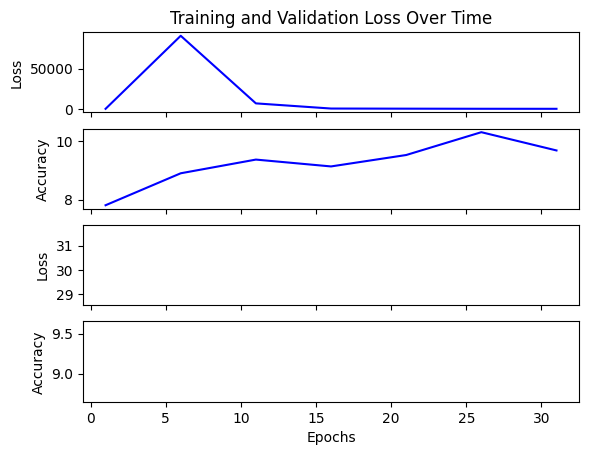

Epoch 2
Batch1, Loss: 8.978, Accuracy: 10.5%
Batch6, Loss: 6.116, Accuracy: 10.8%
Batch11, Loss: 5.581, Accuracy: 9.2%
Batch16, Loss: 3.385, Accuracy: 9.3%
Batch21, Loss: 2.787, Accuracy: 9.9%
Batch26, Loss: 2.444, Accuracy: 10.8%
Batch31, Loss: 2.760, Accuracy: 8.5%
Val Loss: 2.321, Val Accuracy: 9.7%
*****************************************



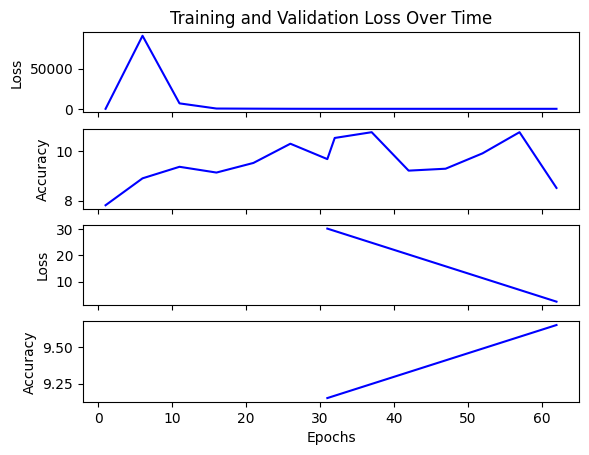

Epoch 3
Batch1, Loss: 4.979, Accuracy: 10.5%
Batch6, Loss: 4.337, Accuracy: 10.2%
Batch11, Loss: 2.505, Accuracy: 9.2%
Batch16, Loss: 2.491, Accuracy: 9.8%
Batch21, Loss: 2.405, Accuracy: 9.2%
Batch26, Loss: 2.341, Accuracy: 11.6%
Batch31, Loss: 2.341, Accuracy: 10.0%
Val Loss: 2.303, Val Accuracy: 9.2%
*****************************************



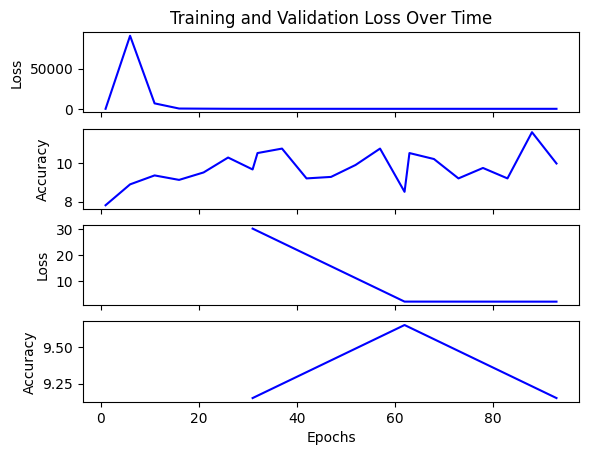

Epoch 4
Batch1, Loss: 2.325, Accuracy: 9.4%
Batch6, Loss: 2.315, Accuracy: 11.4%
Batch11, Loss: 2.305, Accuracy: 11.2%
Batch16, Loss: 2.307, Accuracy: 9.7%
Batch21, Loss: 2.304, Accuracy: 10.0%
Batch26, Loss: 2.304, Accuracy: 9.5%
Batch31, Loss: 2.302, Accuracy: 10.7%
Val Loss: 2.303, Val Accuracy: 9.2%
*****************************************



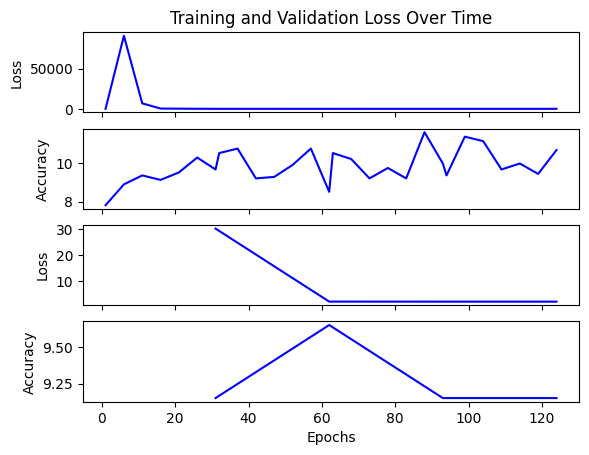

Epoch 5
Batch1, Loss: 2.302, Accuracy: 10.5%
Batch6, Loss: 2.303, Accuracy: 10.1%
Batch11, Loss: 2.303, Accuracy: 9.6%
Batch16, Loss: 2.303, Accuracy: 10.2%
Batch21, Loss: 2.303, Accuracy: 10.2%
Batch26, Loss: 2.303, Accuracy: 10.2%
Batch31, Loss: 2.303, Accuracy: 10.2%
Val Loss: 2.303, Val Accuracy: 9.2%
*****************************************



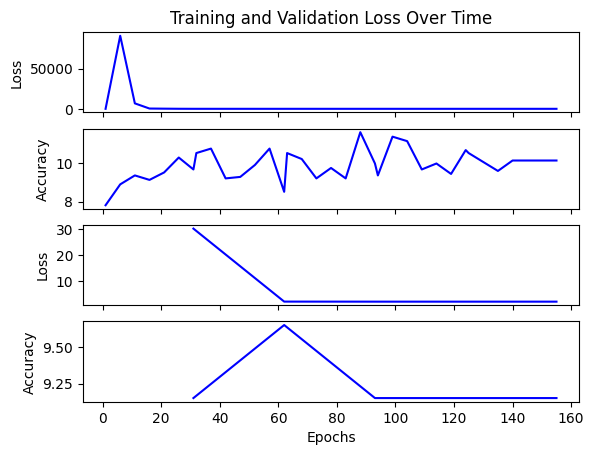

Epoch 6
Batch1, Loss: 2.303, Accuracy: 9.0%
Batch6, Loss: 2.303, Accuracy: 11.1%
Batch11, Loss: 2.303, Accuracy: 9.7%
Batch16, Loss: 2.302, Accuracy: 11.8%
Batch21, Loss: 2.303, Accuracy: 8.7%
Batch26, Loss: 2.303, Accuracy: 9.5%
Batch31, Loss: 2.303, Accuracy: 9.8%
Val Loss: 2.303, Val Accuracy: 9.2%
*****************************************



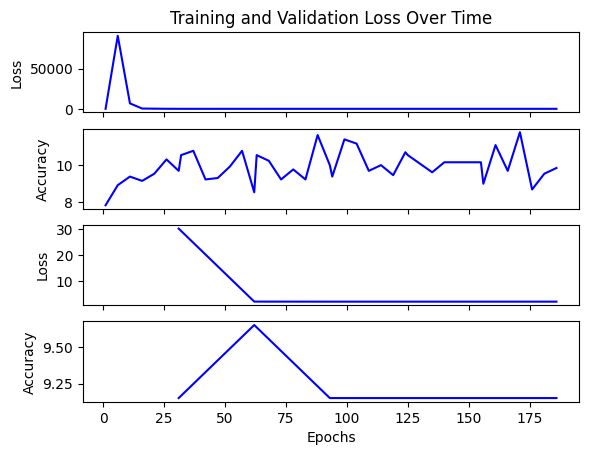

Epoch 7
Batch1, Loss: 2.302, Accuracy: 11.3%
Batch6, Loss: 2.303, Accuracy: 10.5%
Batch11, Loss: 2.303, Accuracy: 10.1%
Batch16, Loss: 2.303, Accuracy: 9.9%
Batch21, Loss: 2.302, Accuracy: 10.9%
Batch26, Loss: 2.303, Accuracy: 9.9%
Batch31, Loss: 2.303, Accuracy: 8.8%
Val Loss: 2.303, Val Accuracy: 9.2%
*****************************************



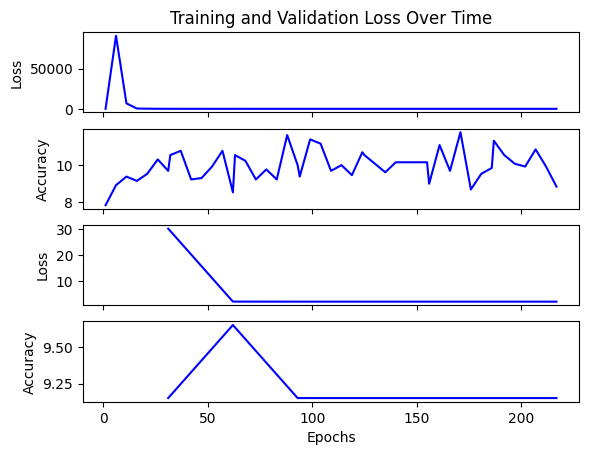

Epoch 8
Batch1, Loss: 2.302, Accuracy: 12.9%
Batch6, Loss: 2.303, Accuracy: 8.9%
Batch11, Loss: 2.303, Accuracy: 9.5%
Batch16, Loss: 2.303, Accuracy: 11.2%
Batch21, Loss: 2.303, Accuracy: 9.1%
Batch26, Loss: 2.303, Accuracy: 9.5%
Batch31, Loss: 2.303, Accuracy: 10.1%
Val Loss: 2.303, Val Accuracy: 9.2%
*****************************************



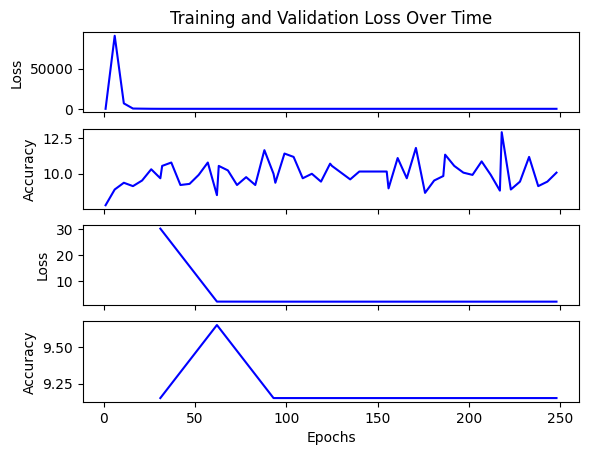

Saved batches_training to Resnet1\batches_training.npy
Saved losses_training to Resnet1\losses_training.npy
Saved accuracies_training to Resnet1\accuracies_training.npy
Saved batches_validation to Resnet1\batches_validation.npy
Saved losses_validation to Resnet1\losses_validation.npy
Saved accuracies_validation to Resnet1\accuracies_validation.npy


In [ ]:
#Sets up CNN, optimizer, and loss function
resnet = Resnet()
resnet.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=0.001)

batches_training = np.array([])
losses_training = np.array([])
accuracies_training  = np.array([])
batches_validation = np.array([])
losses_validation = np.array([])
accuracies_validation = np.array([])

fig = None

#Trains the CNN
num_epochs = 8
for i in range(num_epochs):
    print(f"Epoch {i+1}")
    batches_toadd, losses_toadd, accuracy_toadd = train_epoch(resnet, optimizer, criterion)
    last_batch_num = 0 if len(batches_training) == 0 else batches_training[-1]
    batches_training = np.append(batches_training, (np.array(batches_toadd) + last_batch_num + 1))
    losses_training = np.append(losses_training, losses_toadd)
    accuracies_training = np.append(accuracies_training, accuracy_toadd)

    losses_toadd, accuracy_toadd = validate_epoch(resnet, criterion)
    batches_validation = np.append(batches_validation, batches_training[-1])
    losses_validation = np.append(losses_validation, losses_toadd)
    accuracies_validation = np.append(accuracies_validation, accuracy_toadd)

    #Plot
    if fig:
        plt.close(fig)
    fig = new_plot(batches_training, losses_training, accuracies_training, batches_validation, losses_validation, accuracies_validation)
    
plt.show()

# Save the loss data so that we can process/graph it later
folder_path = "Resnet1"
os.makedirs(folder_path, exist_ok=True)

to_save = {
    "batches_training": batches_training,
    "losses_training": losses_training,
    "accuracies_training": accuracies_training,
    "batches_validation": batches_validation,
    "losses_validation": losses_validation,
    "accuracies_validation": accuracies_validation
}

for name, array in to_save.items():
    file_path = os.path.join(folder_path, f"{name}.npy")
    np.save(file_path, array)
    print(f"Saved {name} to {file_path}")




In [ ]:
losses_training

In [ ]:
#Verifies accuracy on test data set
total_correct = 0
total = 0
resnet.train(False)
for batch_index, data in enumerate(testloader):
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = resnet(inputs)
        total_correct += torch.sum(labels == torch.argmax(outputs, dim=1)).item()
        total += len(outputs)
print(f"Accuracy {(total_correct/total) * 100}")

In [ ]:
torch.save(resnet, 'DeepResNetParams.pth')

In [ ]:
#Loads previously trained models
with torch.serialization.safe_globals([Resnet]):
    resnet = torch.load('DeepResNetParams.pth', weights_only=False)
resnet.to(device)
test_iter = iter(testloader)

In [ ]:
#Shows an image along with a guess and true label
images, true_labels = next(test_iter)
resnet.train(False)
guess_labels = resnet(images.to(device))
np_imgs = images.numpy()
np_img = np_imgs[0]
guess_label = torch.argmax(guess_labels[0]).item()
print(f"True label: {class_names[true_labels[0]][0]}")
print(f"Guess label: {class_names[guess_label][0]}")
plt.imshow(np_img.transpose((1, 2, 0)))